# Výpočet tepové frekvence z EKG signálu 
## Vypracoval Marek Tremel a Radek Novák, F23211 a F23181

**Zadání** : Ve zdrojové databázi najdete celkem 18 měření EKG obsahující úplné (3 signály) nebo částečné
anotace událostí (P,T vlny a QRS komplex). Záznamy EKg obsahují i části, které jsou porušeny
vlivem anomálií (vnější rušení, manipulace s pacientem apod.). Navrhněte způsob, jak
detekovat tyto úseky a prezentujte statistiku výskytu úseků v měřeních.

----------



## Použité knihovny

In [75]:
import wfdb
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

## Parametry pro nastavení zpracování dat

In [76]:
lowcut = 0.5  # Dolní hranice pásmové filtrace (Hz)
highcut = 50.0  # Horní hranice pásmové filtrace (Hz)
filter_order = 4  # Pořadí filtru

## Funkce pro zpracování dat

## Pásmová filtrace

Proces, který propouští signály v určitém frekvenčním rozsahu a zároveň potlačuje signály mimo toto pásmo. 
1. Výpočet Nyquistovy frekvence: Nyquistova frekvence je polovina vzorkovací frekvence (fs). Je to maximální frekvence, kterou lze správně reprezentovat při dané vzorkovací frekvenc
2. Normalizace mezních frekvencí: Dolní a horní mezní frekvence jsou normalizovány vzhledem k Nyquistově frekvenci.
3. Funkce *butter* z knihovny *scipy.signal* navrhne Butterworthův filtr s daným řádem a normalizovanými mezními frekvencemi. Výstupem jsou koeficienty filtru *b* a *a*
4. Funkce *filtfilt* z knihovny *scipy.signal* aplikuje navržený filtr na vstupní signál. Tato funkce provádí obousměrné filtrování, což znamená, že signál je filtrován dopředu i dozadu, aby se minimalizovalo fázové zkreslení.

In [77]:
def bandpass_filter(signal: np.ndarray, lowcut: float, highcut: float, fs: float, order: int) -> np.ndarray:
    """Funkce pro pásmovou filtrační metodu

    Args:
        signal: vstupní signál, který má být filtrován.
        lowcut: dolní mez frekvenčního pásma
        highcut: horní mez frekvenčního pásma.
        fs: vzorkovací frekvence signálu.
        order: řád filtru, který určuje strmost filtru.

    Returns:
        Filtrovaný signál.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, signal)

##  Funkce sloužící k detekci anomálií v signálu na základě prahové hodnoty.

1. Výpočet průměru a směrodatné odchylky signálu
2. Detekce anomálií
    - Pro každý prvek v signálu se vypočítá absolutní rozdíl mezi hodnotou prvku a průměrem.
    - Pokud je tento rozdíl větší než *threshold* násobený směrodatnou odchylkou, index prvku je přidán do seznamu anomálií.
3. Pole indexů, kde byla detekována anomálie.


In [78]:
def detect_anomalies(signal: np.ndarray, threshold: float = 3.0) -> np.ndarray:
    """Detekuje anomálie na základě prahové hodnoty.

    Args:
        signal: signál, ve kterém se mají detekovat anomálie.
        threshold: hodnota, která určuje, kdy je hodnota signálu považována za anomálii.

    Returns:
        Pole indexů, kde byla detekována anomálie.
    """
    mean = np.mean(signal)
    std = np.std(signal)
    anomalies = np.abs(signal - mean) > threshold * std
    return np.nonzero(anomalies)[0]

## Načtení pracovního adresáře

In [79]:
# Hlavní adresář se složkami EKG měření
main_directory = "../data/ekg/"

# Pro jednu konkrétní složku detekujeme anomálie
ekg_directory = os.path.join(main_directory, "100002")

# Načtení všech dostupných souborů ve složce
files = os.listdir(ekg_directory)
signal_basenames = set(f.split(".")[0] for f in files if f.endswith("ECG.dat"))

1. Kontrola existence dat
2. Výběr prvního souboru a příprava cesty
3. Načtení EKG signálu
4. Získání vzorkovací frekvence:
    - Z metadat (**fields**) se vytáhne vzorkovací frekvence (**fs**), což je počet vzorků za sekundu. 
5. Omezení na prvních 3000 vzorků ... kvůli náročnosti jsem to musel omezit.
6. Normalizace signálu:
    - Signál se převede tak, aby měl průměr (**mean**) 0 a směrodatnou odchylku (**std**) 1.
    - Tento krok je k tomu, aby detekce anomálií nebyly ovlivněny různými amplitudami mezi signály.
7. Aplikace pásmové filtrace
8. Detekce anomálií


In [80]:
if len(signal_basenames) > 0:
    signal_basename = list(signal_basenames)[0]
    record_path = os.path.join(ekg_directory, signal_basename)

    # Načtení signálu
    record = wfdb.rdsamp(record_path)
    signal = record[0][:, 0]  # První kanál
    fields = record[1]

    # Vzorkovací frekvence (Hz)
    sampling_frequency = fields["fs"] 
    

    # Pouze prvních 3000 vzorků
    # Omezení, kvůli náročnosti výpočtu
    def select_range(signal: np.ndarray, start: int, end: int) -> np.ndarray:
        return signal[start:end]
    signal = select_range(signal, 0, 3000)

    # Normalizace signálu
    signal_normalized = (signal - np.mean(signal)) / np.std(signal)

    # Aplikace filtrace
    try:
        signal_processed = bandpass_filter(signal_normalized, lowcut, highcut, sampling_frequency, filter_order)
    except ValueError as e:
        print(f"Chyba filtrace: {e}")
        signal_processed = signal_normalized

    # Detekce anomálií
    anomalies = detect_anomalies(signal_processed)

## Vykreslení grafů

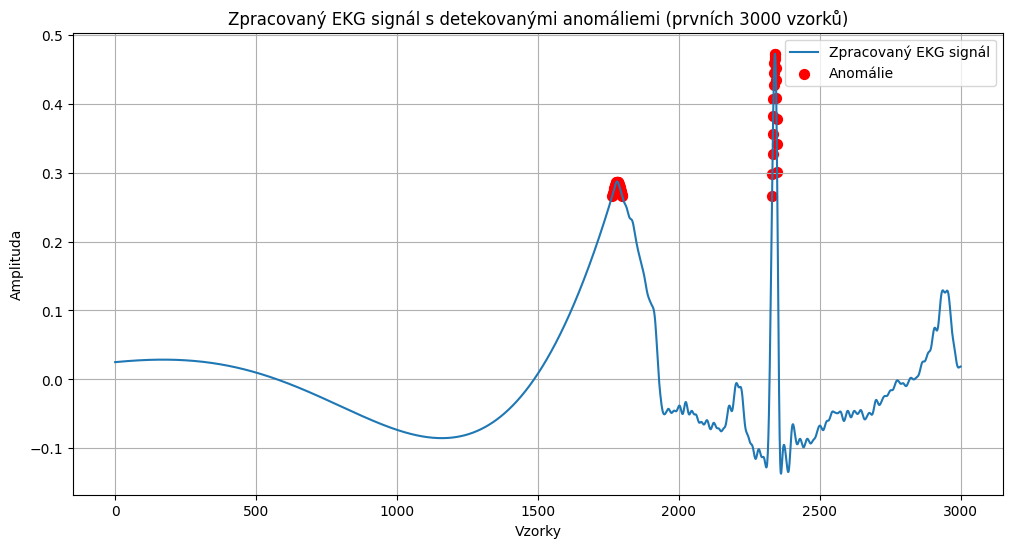

In [81]:
# Vykreslení celého signálu s označenými anomáliemi
if len(signal_basenames) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(signal_processed, label="Zpracovaný EKG signál")
    plt.scatter(anomalies, signal_processed[anomalies], color="red", label="Anomálie", s=50)
    plt.title("Zpracovaný EKG signál s detekovanými anomáliemi (prvních 3000 vzorků)")
    plt.xlabel("Vzorky")
    plt.ylabel("Amplituda")
    plt.legend()
    plt.grid()
    plt.show()
    
    
 # # Vykreslení jednotlivých anomálních úseků
    # for anomaly in anomalies:
    #     start = max(0, anomaly - 100)
    #     end = min(len(signal_processed), anomaly + 100)
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(range(start, end), signal_processed[start:end], label="Anomální úsek")
    #     plt.axvline(x=anomaly, color="red", linestyle="--", label="Anomálie")
    #     plt.title("Detail anomálního úseku")
    #     plt.xlabel("Vzorky")
    #     plt.ylabel("Amplituda")
    #     plt.legend()
    #     plt.grid()
    #     plt.show()

## Slovni hodnocení

V rámci tohoto projektu zaměřeného na detekci anomálií v EKG signálu jsem se soustředil na  načítání a zpracování EKG signálu pomocí Pythonu. 
Cílem bylo nejen správně načíst data, ale i aplikovat vhodné metody pro objevení anomálií v signálu.

Pro detekci anomálií jsem využil metodu založenou na prahové hodnotě. Po výpočtu průměru a směrodatné odchylky signálu byly identifikovány odchylky, které výrazně překračovaly běžné hodnoty.

Projekt mi poskytl pohled do práce s EKG signálem. Jak data zpracovat, a jak je důležité parametry správně nastavit.